# CHAPTER 14 Data Analysis Examples（数据分析实例）

# 14.1 USA.gov Data from Bitly（USA.gov数据集）

2011年，短链接服务（URL shortening service）商[Bitly](https://bitly.com/)和美国政府网站[USA.gov](https://www.usa.gov/)合作，提供了一份从用户中收集来的匿名数据，这些用户使用了结尾为.gov或.mil的短链接。在2011年，这些数据的动态信息每小时都会保存一次，并可供下载。不过在2017年，这项服务被停掉了。

数据是每小时更新一次，文件中的每一行都用JOSN（JavaScript Object Notation）格式保存。我们先读取几行看一下数据是什么样的：

In [1]:
path = '../datasets/bitly_usagov/example.txt'

In [2]:
open(path).readline()

'{ "a": "Mozilla\\/5.0 (Windows NT 6.1; WOW64) AppleWebKit\\/535.11 (KHTML, like Gecko) Chrome\\/17.0.963.78 Safari\\/535.11", "c": "US", "nk": 1, "tz": "America\\/New_York", "gr": "MA", "g": "A6qOVH", "h": "wfLQtf", "l": "orofrog", "al": "en-US,en;q=0.8", "hh": "1.usa.gov", "r": "http:\\/\\/www.facebook.com\\/l\\/7AQEFzjSi\\/1.usa.gov\\/wfLQtf", "u": "http:\\/\\/www.ncbi.nlm.nih.gov\\/pubmed\\/22415991", "t": 1331923247, "hc": 1331822918, "cy": "Danvers", "ll": [ 42.576698, -70.954903 ] }\n'

python有很多内置的模块能把JSON字符串转换成Python字典对象。这里我们用JSON模块：

In [6]:
import json
path = '../datasets/bitly_usagov/example.txt'
records = [json.loads(line) for line in open(path)]

上面这种方法叫做列表推导式, list comprehension, 在一组字符串上执行一条相同操作（比如这里的json.loads）。结果对象records现在是一个由dict组成的list：

In [7]:
records[0]

{'a': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/535.11 (KHTML, like Gecko) Chrome/17.0.963.78 Safari/535.11',
 'al': 'en-US,en;q=0.8',
 'c': 'US',
 'cy': 'Danvers',
 'g': 'A6qOVH',
 'gr': 'MA',
 'h': 'wfLQtf',
 'hc': 1331822918,
 'hh': '1.usa.gov',
 'l': 'orofrog',
 'll': [42.576698, -70.954903],
 'nk': 1,
 'r': 'http://www.facebook.com/l/7AQEFzjSi/1.usa.gov/wfLQtf',
 't': 1331923247,
 'tz': 'America/New_York',
 'u': 'http://www.ncbi.nlm.nih.gov/pubmed/22415991'}

In [9]:
records[0]['tz']

'America/New_York'

# 1 Counting Time Zones in Pure Python（用纯python代码对时区进行计数）

我们想知道数据集中出现在哪个时区（即tz字段）

In [10]:
time_zones = [rec['tz'] for rec in records]

KeyError: 'tz'

看来并不是所有的记录都有时区字段。那么只需要在推导式的末尾加一个if 'tz' in rec判断即可

In [11]:
time_zones = [rec['tz'] for rec in records if 'tz' in rec]

In [12]:
time_zones[:10]

['America/New_York',
 'America/Denver',
 'America/New_York',
 'America/Sao_Paulo',
 'America/New_York',
 'America/New_York',
 'Europe/Warsaw',
 '',
 '',
 '']

在这10条时区信息中，可以看到有些是空字符串，现在先留着。

为了对时区进行计数，我们用两种方法：一个用纯python代码，比较麻烦。另一个用pandas，比较简单。 这里我们先介绍使用纯python代码的方法：

遍历时区的过程中将计数值保存在字典中：

In [22]:
def get_counts(sequence):
    counts = {}
    for x in sequence:
        if x in counts:
            counts[x] += 1
        else:
            counts[x] = 1
    return counts

使用python标准库的话，能把代码写得更简洁一些：

In [23]:
from collections import defaultdict

def get_counts2(sequence):
    counts = defaultdict(int) # 所有的值均会被初始化为0
    for x in sequence:
        counts[x] += 1
    return counts

（译者：下面关于defaultdict的用法是我从Stack Overflow上找到的，英文比较多，简单的说就是通常如果一个字典里不存在一个key，调用的时候会报错，但是如果我们设置了了default，就不会被报错，而是会新建一个key，对应的value就是我们设置的int，这里int代表0）

> **defaultdict** means that if a key is not found in the dictionary, then instead of a KeyError being thrown, a new entry is created. The type of this new entry is given by the argument of defaultdict.

    somedict = {}
    print(somedict[3]) # KeyError

    someddict = defaultdict(int)
    print(someddict[3]) # print int(), thus 0


>Usually, a Python dictionary throws a KeyError if you try to get an item with a key that is not currently in the dictionary. The defaultdict in contrast will simply create any items that you try to access (provided of course they do not exist yet). To create such a "default" item, it calls the function object that you pass in the constructor (more precisely, it's an arbitrary "callable" object, which includes function and type objects). For the first example, default items are created using `int()`, which will return the integer object 0. For the second example, default items are created using `list()`, which returns a new empty list object.



In [24]:
someddict = defaultdict(int)
print(someddict[3])

0


In [25]:
someddict[3]

0

上面用函数的方式写出来是为了有更高的可用性。要对它进行时区处理，只需要将time_zones传入即可：

In [26]:
counts = get_counts(time_zones)

In [28]:
counts['America/New_York']

1251

In [29]:
len(time_zones)

3440

如何想要得到前10位的时区及其计数值，我们需要一些有关字典的处理技巧：

In [31]:
def top_counts(count_dict, n=10):
    value_key_pairs = [(count, tz) for tz, count in count_dict.items()]
    value_key_pairs.sort()
    return value_key_pairs[-n:]

In [32]:
top_counts(counts)

[(33, 'America/Sao_Paulo'),
 (35, 'Europe/Madrid'),
 (36, 'Pacific/Honolulu'),
 (37, 'Asia/Tokyo'),
 (74, 'Europe/London'),
 (191, 'America/Denver'),
 (382, 'America/Los_Angeles'),
 (400, 'America/Chicago'),
 (521, ''),
 (1251, 'America/New_York')]

如果用python标准库里的collections.Counter类，能让这个任务变得更简单

In [33]:
from collections import Counter

In [34]:
counts = Counter(time_zones)

In [35]:
counts.most_common(10)

[('America/New_York', 1251),
 ('', 521),
 ('America/Chicago', 400),
 ('America/Los_Angeles', 382),
 ('America/Denver', 191),
 ('Europe/London', 74),
 ('Asia/Tokyo', 37),
 ('Pacific/Honolulu', 36),
 ('Europe/Madrid', 35),
 ('America/Sao_Paulo', 33)]

# 2 Counting Time Zones with pandas（用pandas对时区进行计数）

从一组原始记录中创建DataFrame是很简单的，直接把records传递给pandas.DataFrame即可：


In [20]:
import pandas as pd
import numpy as np

In [8]:
frame = pd.DataFrame(records)

In [9]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3560 entries, 0 to 3559
Data columns (total 18 columns):
_heartbeat_    120 non-null float64
a              3440 non-null object
al             3094 non-null object
c              2919 non-null object
cy             2919 non-null object
g              3440 non-null object
gr             2919 non-null object
h              3440 non-null object
hc             3440 non-null float64
hh             3440 non-null object
kw             93 non-null object
l              3440 non-null object
ll             2919 non-null object
nk             3440 non-null float64
r              3440 non-null object
t              3440 non-null float64
tz             3440 non-null object
u              3440 non-null object
dtypes: float64(4), object(14)
memory usage: 500.7+ KB


In [41]:
frame['tz'][:10]

0     America/New_York
1       America/Denver
2     America/New_York
3    America/Sao_Paulo
4     America/New_York
5     America/New_York
6        Europe/Warsaw
7                     
8                     
9                     
Name: tz, dtype: object

这里frame的输出形式是summary view, 主要用于较大的dataframe对象。frame['tz']所返回的Series对象有一个value_counts方法，该方法可以让我们得到想要的信息:

In [10]:
tz_counts = frame['tz'].value_counts()

In [11]:
tz_counts[:10]

America/New_York       1251
                        521
America/Chicago         400
America/Los_Angeles     382
America/Denver          191
Europe/London            74
Asia/Tokyo               37
Pacific/Honolulu         36
Europe/Madrid            35
America/Sao_Paulo        33
Name: tz, dtype: int64

我们能利用matplotlib为这段数据生成一张图片。这里我们先给记录中未知或缺失的时区填上一个替代值。fillna函数可以替代缺失值（NA），而未知值（空字符串）则可以通过布尔型数组索引，加以替换：

In [45]:
clean_tz = frame['tz'].fillna('Missing')

In [46]:
clean_tz[clean_tz == ''] = 'Unknown'

In [47]:
tz_counts = clean_tz.value_counts()

In [48]:
tz_counts[:10]

America/New_York       1251
Unknown                 521
America/Chicago         400
America/Los_Angeles     382
America/Denver          191
Missing                 120
Europe/London            74
Asia/Tokyo               37
Pacific/Honolulu         36
Europe/Madrid            35
Name: tz, dtype: int64

利用counts对象的plot方法即可得到一张水平条形图：

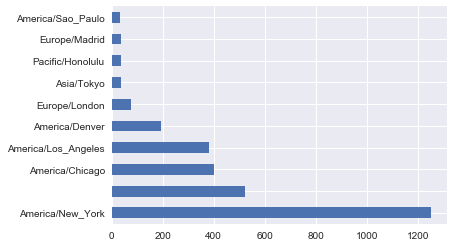

In [15]:
%matplotlib inline
tz_counts[:10].plot(kind='barh', rot=0)

当然，我们也可以使用之前介绍的seaborn来画一个水平条形图（horizontal bar plot）：

In [16]:
import seaborn as sns

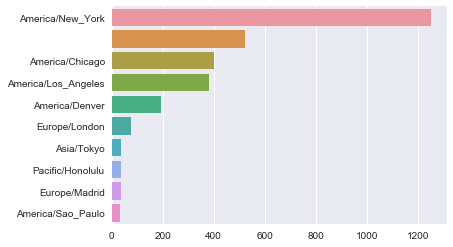

In [17]:
subset = tz_counts[:10]
sns.barplot(y=subset.index, x=subset.values)

我们还可以对这种数据进行更多的处理。比如a字段含有执行URL操作的浏览器、设备、应用程序的相关信息：

In [53]:
frame['a'][1]

'GoogleMaps/RochesterNY'

In [54]:
frame['a'][50]

'Mozilla/5.0 (Windows NT 5.1; rv:10.0.2) Gecko/20100101 Firefox/10.0.2'

In [55]:
frame['a'][51]

'Mozilla/5.0 (Linux; U; Android 2.2.2; en-us; LG-P925/V10e Build/FRG83G) AppleWebKit/533.1 (KHTML, like Gecko) Version/4.0 Mobile Safari/533.1'

In [58]:
frame['a'][:5]

0    Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
1                               GoogleMaps/RochesterNY
2    Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...
3    Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8)...
4    Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
Name: a, dtype: object

将这些USER_AGENT字符串中的所有信息都解析出来是一件挺郁闷的工作。不过只要掌握了Python内置的字符串函数和正则表达式，就方便了。比如，我们可以把字符串的第一节（与浏览器大致对应）分离出来得到另一份用户行为摘要：

In [59]:
results = Series([x.split()[0] for x in frame.a.dropna()])

In [60]:
results[:5]

0               Mozilla/5.0
1    GoogleMaps/RochesterNY
2               Mozilla/4.0
3               Mozilla/5.0
4               Mozilla/5.0
dtype: object

In [61]:
results.value_counts()[:8]

Mozilla/5.0                 2594
Mozilla/4.0                  601
GoogleMaps/RochesterNY       121
Opera/9.80                    34
TEST_INTERNET_AGENT           24
GoogleProducer                21
Mozilla/6.0                    5
BlackBerry8520/5.0.0.681       4
dtype: int64

现在，假设我们想按Windows和非Windows用户对时区统计信息进行分解。为了简单期间，我们假定只要agent字符串中含有“windows”就认为该用户是windows用户。由于有的agent缺失，所以先将他们从数据中移除：

In [18]:
cframe = frame[frame.a.notnull()]
cframe.head()

,_heartbeat_,a,al,c,cy,g,gr,h,hc,hh,kw,l,ll,nk,r,t,tz,u
0,NaN,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,"en-US,en;q=0.8",US,Danvers,A6qOVH,MA,wfLQtf,1.331823e+09,1.usa.gov,NaN,orofrog,"[42.576698, -70.954903]",1.0,http://www.facebook.com/l/7AQEFzjSi/1.usa.gov/...,1.331923e+09,America/New_York,http://www.ncbi.nlm.nih.gov/pubmed/22415991
1,NaN,GoogleMaps/RochesterNY,NaN,US,Provo,mwszkS,UT,mwszkS,1.308262e+09,j.mp,NaN,bitly,"[40.218102, -111.613297]",0.0,http://www.AwareMap.com/,1.331923e+09,America/Denver,http://www.monroecounty.gov/etc/911/rss.php
2,NaN,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,en-US,US,Washington,xxr3Qb,DC,xxr3Qb,1.331920e+09,1.usa.gov,NaN,bitly,"[38.9007, -77.043098]",1.0,http://t.co/03elZC4Q,1.331923e+09,America/New_York,http://boxer.senate.gov/en/press/releases/0316...
3,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8)...,pt-br,BR,Braz,zCaLwp,27,zUtuOu,1.331923e+09,1.usa.gov,NaN,alelex88,"[-23.549999, -46.616699]",0.0,direct,1.331923e+09,America/Sao_Paulo,http://apod.nasa.gov/apod/ap120312.html
4,NaN,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,"en-US,en;q=0.8",US,Shrewsbury,9b6kNl,MA,9b6kNl,1.273672e+09,bit.ly,NaN,bitly,"[42.286499, -71.714699]",0.0,http://www.shrewsbury-ma.gov/selco/,1.331923e+09,America/New_York,http://www.shrewsbury-ma.gov/egov/gallery/1341...


其次根据a值计算出各行是否是windows：

In [22]:
cframe['os'] = np.where(cframe['a'].str.contains('Windows'), 
                            'Windows', 'Not Windows')

/Users/xu/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [23]:
cframe['os'][:5]

0        Windows
1    Not Windows
2        Windows
3    Not Windows
4        Windows
Name: os, dtype: object

接下来就可以根据时区和新得到的操作系统列表对数据进行分组了：

In [24]:
by_tz_os = cframe.groupby(['tz', 'os'])

In [25]:
by_tz_os.size()

tz                              os         
                                Not Windows    245
                                Windows        276
Africa/Cairo                    Windows          3
Africa/Casablanca               Windows          1
Africa/Ceuta                    Windows          2
Africa/Johannesburg             Windows          1
Africa/Lusaka                   Windows          1
America/Anchorage               Not Windows      4
                                Windows          1
America/Argentina/Buenos_Aires  Not Windows      1
America/Argentina/Cordoba       Windows          1
America/Argentina/Mendoza       Windows          1
America/Bogota                  Not Windows      1
                                Windows          2
America/Caracas                 Windows          1
America/Chicago                 Not Windows    115
                                Windows        285
America/Chihuahua               Not Windows      1
                                Window

上面通过size对分组结果进行计数，类似于value_counts函数，并利用unstack对计数结果进行重塑为一个表格：

In [26]:
agg_counts = by_tz_os.size().unstack().fillna(0)

In [27]:
agg_counts[:10]

os,Not Windows,Windows
tz,,
,245.0,276.0
Africa/Cairo,0.0,3.0
Africa/Casablanca,0.0,1.0
Africa/Ceuta,0.0,2.0
Africa/Johannesburg,0.0,1.0
Africa/Lusaka,0.0,1.0
America/Anchorage,4.0,1.0
America/Argentina/Buenos_Aires,1.0,0.0
America/Argentina/Cordoba,0.0,1.0


最后，我们来选取最常出现的时区。为了达到这个目的，根据agg_counts中的行数构造了一个简洁索引数组：

In [28]:
indexer = agg_counts.sum(1).argsort()
indexer[:10]

tz
                                  24
Africa/Cairo                      20
Africa/Casablanca                 21
Africa/Ceuta                      92
Africa/Johannesburg               87
Africa/Lusaka                     53
America/Anchorage                 54
America/Argentina/Buenos_Aires    57
America/Argentina/Cordoba         26
America/Argentina/Mendoza         55
dtype: int64

In [83]:
indexer = agg_counts.sum(1).argsort()
indexer[:10]

tz
                                  24
Africa/Cairo                      20
Africa/Casablanca                 21
Africa/Ceuta                      92
Africa/Johannesburg               87
Africa/Lusaka                     53
America/Anchorage                 54
America/Argentina/Buenos_Aires    57
America/Argentina/Cordoba         26
America/Argentina/Mendoza         55
dtype: int64

然后通过take按照这个顺序截取了最后10行：

In [29]:
count_subset = agg_counts.take(indexer)[-10:]
count_subset

os,Not Windows,Windows
tz,,
America/Sao_Paulo,13.0,20.0
Europe/Madrid,16.0,19.0
Pacific/Honolulu,0.0,36.0
Asia/Tokyo,2.0,35.0
Europe/London,43.0,31.0
America/Denver,132.0,59.0
America/Los_Angeles,130.0,252.0
America/Chicago,115.0,285.0
,245.0,276.0


pandas有一个很方便的方法叫nlargest，可以实现相同效果：

In [30]:
agg_counts.sum(1).nlargest(10)

tz
America/New_York       1251.0
                        521.0
America/Chicago         400.0
America/Los_Angeles     382.0
America/Denver          191.0
Europe/London            74.0
Asia/Tokyo               37.0
Pacific/Honolulu         36.0
Europe/Madrid            35.0
America/Sao_Paulo        33.0
dtype: float64

上面的输出结果可以画成条形图；通过给seaborn的barplot函数传递一个参数，来画出堆积条形图（stacked bar plot）：

In [31]:
# Rearrange the data for plotting
count_subset = count_subset.stack()
count_subset.head()

tz                 os         
America/Sao_Paulo  Not Windows    13.0
                   Windows        20.0
Europe/Madrid      Not Windows    16.0
                   Windows        19.0
Pacific/Honolulu   Not Windows     0.0
dtype: float64

In [33]:
count_subset.name = 'total'
count_subset = count_subset.reset_index()
count_subset[:10]

,tz,os,total
0,America/Sao_Paulo,Not Windows,13.0
1,America/Sao_Paulo,Windows,20.0
2,Europe/Madrid,Not Windows,16.0
3,Europe/Madrid,Windows,19.0
4,Pacific/Honolulu,Not Windows,0.0
5,Pacific/Honolulu,Windows,36.0
6,Asia/Tokyo,Not Windows,2.0
7,Asia/Tokyo,Windows,35.0
8,Europe/London,Not Windows,43.0
9,Europe/London,Windows,31.0


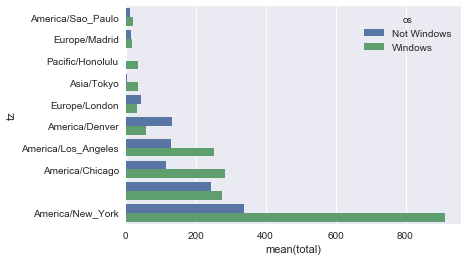

In [34]:
sns.barplot(x='total', y='tz', hue='os', data=count_subset)

由于这张图中不太容易看清楚较小分组中windows用户的相对比例，因此我们可以将各行规范化为“总计为1”并重新绘图：

In [37]:
def norm_total(group):
    group['normed_total'] = group.total / group.total.sum()
    return group

results = count_subset.groupby('tz').apply(norm_total)

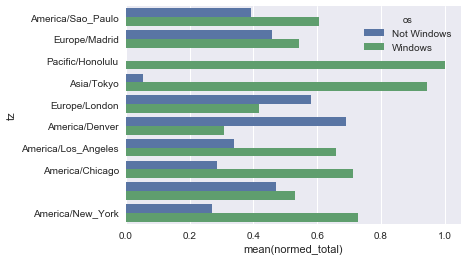

In [38]:
sns.barplot(x='normed_total', y='tz', hue='os', data=results)

我们还可以使用transform和groupby，来更有效率地计算规范化的和：

In [39]:
g = count_subset.groupby('tz')
results2 = count_subset.total / g.total.transform('sum')

译者：下面的内容是不适用seaborn的画图方法，这种画法是2013年第一版中的内容：

In [41]:
count_subset = agg_counts.take(indexer)[-10:]
count_subset

os,Not Windows,Windows
tz,,
America/Sao_Paulo,13.0,20.0
Europe/Madrid,16.0,19.0
Pacific/Honolulu,0.0,36.0
Asia/Tokyo,2.0,35.0
Europe/London,43.0,31.0
America/Denver,132.0,59.0
America/Los_Angeles,130.0,252.0
America/Chicago,115.0,285.0
,245.0,276.0


这里也可以生成一张条形图。我们使用stacked=True来生成一张堆积条形图：

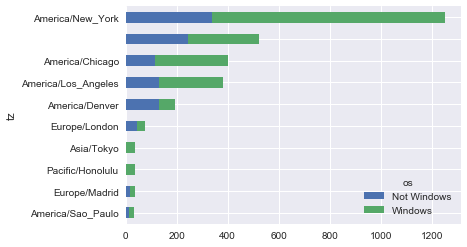

In [42]:
count_subset.plot(kind='barh', stacked=True)

由于这张图中不太容易看清楚较小分组中windows用户的相对比例，因此我们可以将各行规范化为“总计为1”并重新绘图：

In [43]:
normed_subset = count_subset.div(count_subset.sum(1), axis=0)

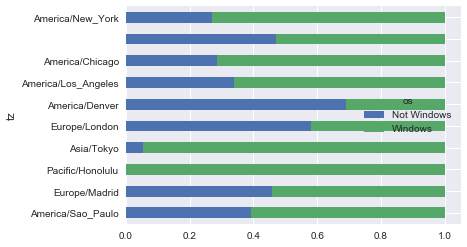

In [44]:
normed_subset.plot(kind='barh', stacked=True)